## to get the data -> run wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip 

In [1]:
import os
import rasterio
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import seaborn as sn
import pandas as pd


from IPython.display import clear_output

import torch
from torch.nn import Conv2d, Linear
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader

# Set the Parameters

In [2]:
# set the path to the folder which contains the sub-directries with the ten classes
datapath = "/media/jp/data/datasets/EuroSat/EuroSATallBands/ds/images/remote_sensing/otherDatasets/sentinel_2/tif"

# Model and Trainings Parameters
batch_size = 16
threads = 6
learning_rate = 0.001
momentum = 0.9

### Show one example image 


--> we will only work with the four 10m channels

In [3]:
path_to_preview = glob.glob(os.path.join(datapath,"**","*.tif"),recursive=True)
with rasterio.open(path_to_preview[0],"r") as src:
    tempdata = src.read((2,3,4,8))
tempdata.shape

(4, 64, 64)

plot the bands to ensure we have choosen the high resoluton images (B02,B03,B04,B08)

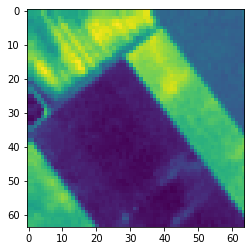

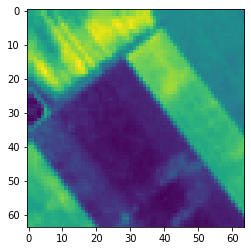

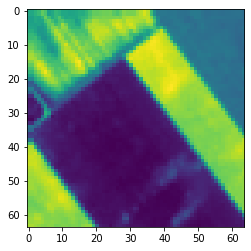

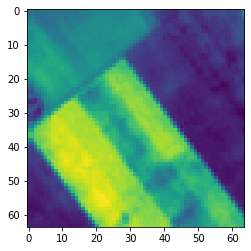

In [4]:
for x in tempdata:
    plt.imshow(x)
    plt.show()

### Do some preperations

In [5]:
RS = np.random.RandomState(seed=69422)

# make sure you set the path correctly
classes = os.listdir(datapath)
assert classes == ['AnnualCrop','Pasture','PermanentCrop','SeaLake','Forest','Highway','River','HerbaceousVegetation','Industrial','Residential']

### Get the model

In [6]:
model = models.vgg19()
model.cuda()
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

### Adapt the model to the S2 images
change first and last layer to match a four channel input and ten class classification problem

In [7]:
model = models.vgg19()
model.features[0] = Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[-1] = Linear(in_features=4096, out_features=10, bias=True)
model.cuda()
summary(model,(4,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,368
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

### Functions that collect all the images and corresponding class labels

We restrict the number of images per class to 2k to have a balanced dataset... otherwise this could also be adressed in the loss function

In [8]:
def get_list_of_sampels(datapath):

    sample_toupels = [] 
    
    for ijk, _class in enumerate(classes):
        
        all_sampels_in_class = glob.glob(os.path.join(datapath,_class,"*.tif"))
        all_sampels_in_class = all_sampels_in_class[:2000]

        for sample in all_sampels_in_class:
            sample_toupels.append({"X":sample,"Y":ijk})
            
    return sample_toupels

### write the dataloader

In [9]:
class SR_dataset(data.Dataset):

    def __init__(self, samplelist):

        self.samplelist = samplelist

    def __getitem__(self, i):
        
        with rasterio.open(self.samplelist[i]["X"],"r") as src:
            
            ###################
            # Max reflection for a S2 image is @ 10k pixel value
            # we will normalize that to [0,1] range
            ###################
            
            data = src.read((2,3,4,8)).astype("float32")
            data = data/10000
            data = np.clip(data,0,1)

        return torch.Tensor(data), torch.Tensor([self.samplelist[i]["Y"]]).long()

    def __len__(self):
        return len(self.samplelist)

### setup pytorch dataloader

# Train Images 15000
# Val Images 5000


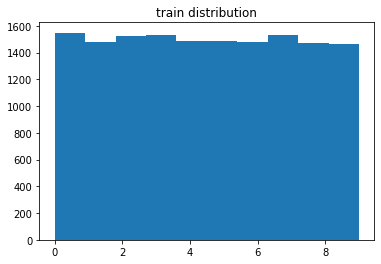

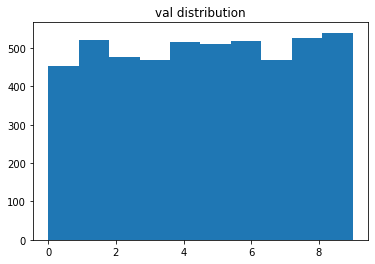

In [10]:
all_sampels = get_list_of_sampels(datapath)

RS.shuffle(all_sampels)

train_locations = all_sampels[:15000]
val_locations = all_sampels[-5000:]

print("# Train Images",len(train_locations))
print("# Val Images",len(val_locations))


temp_hist = []
for d in train_locations:
    temp_hist.append(d["Y"])
plt.hist(temp_hist)
plt.title("train distribution")
plt.show()


temp_hist = []
for d in val_locations:
    temp_hist.append(d["Y"])
plt.hist(temp_hist)
plt.title("val distribution")
plt.show()

In [11]:
train_set = SR_dataset(train_locations)
val_set = SR_dataset(val_locations)

In [12]:
# Setup the dataloader
training_data_loader = DataLoader(dataset=train_set, num_workers=threads,
    batch_size=batch_size, shuffle=True, drop_last=True)

val_data_loader = DataLoader(dataset=val_set, num_workers=threads,
    batch_size=batch_size, shuffle=True, drop_last=True)

### Show one batch

torch.Size([16, 4, 64, 64]) torch.Size([16, 1])


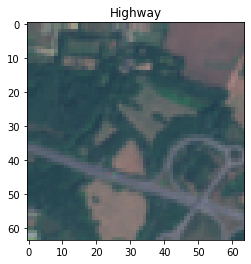

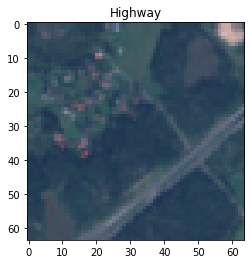

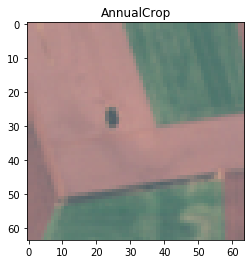

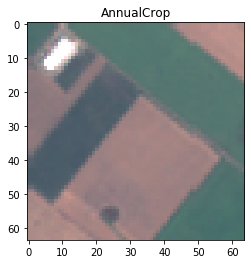

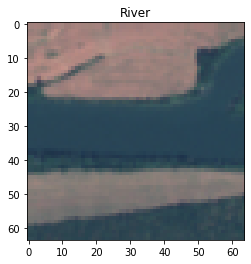

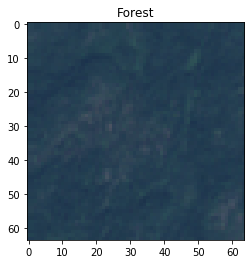

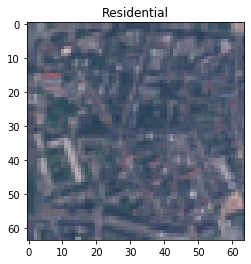

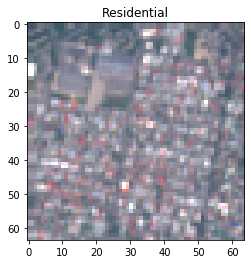

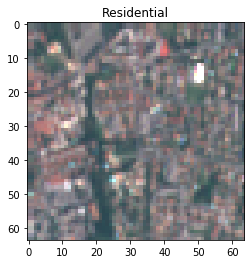

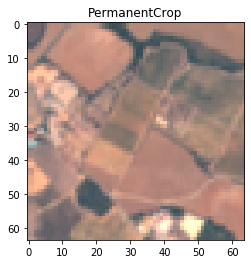

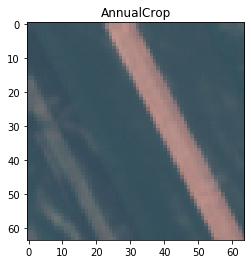

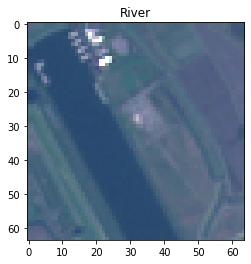

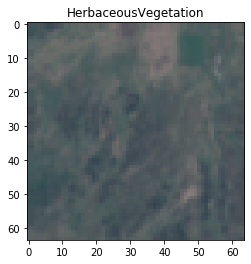

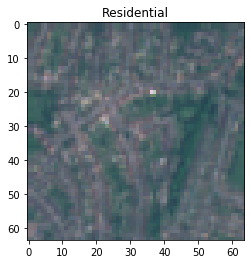

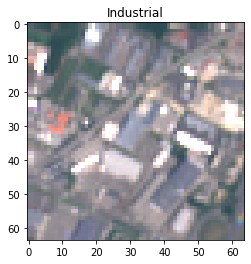

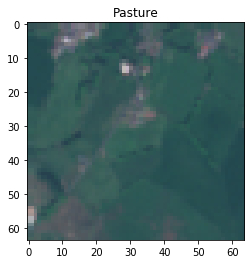

In [13]:
for img, label in val_data_loader:
    break
    
print(img.shape,label.shape)

for batchindex in range(batch_size):

    B,G,R = img[batchindex,:3,:,:]
    plot_img = np.stack([R,G,B],axis=-1)
    plot_img = np.clip(plot_img*4,0,1) # make it brighter


    plt.imshow(plot_img)
    plt.title(classes[label[batchindex].numpy()[0]])
    plt.show()

### Set up the loss function

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Training

In [15]:
def calc_conf_matrix(loader, model, classes):

    model.eval()
    
    nb_classes = len(classes)
    
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(loader):

            inputs = inputs.cuda()
            classes = classes.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
       
    model.train()
    
    return confusion_matrix


def plot_conf_matrix(cm,savepath = ""):
    
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    if savepath != "":
        plt.savefig(savepath,dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()
        
    else:
        plt.show()
    



def eval_model(loader, model):

    model.eval()
    
    loss = []
    
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(loader):

            inputs = inputs.cuda()
            classes = classes.cuda()

            loss.append(criterion(outputs, labels).item())


    model.train()
    
    return np.mean(loss)

#### Start trainings loop

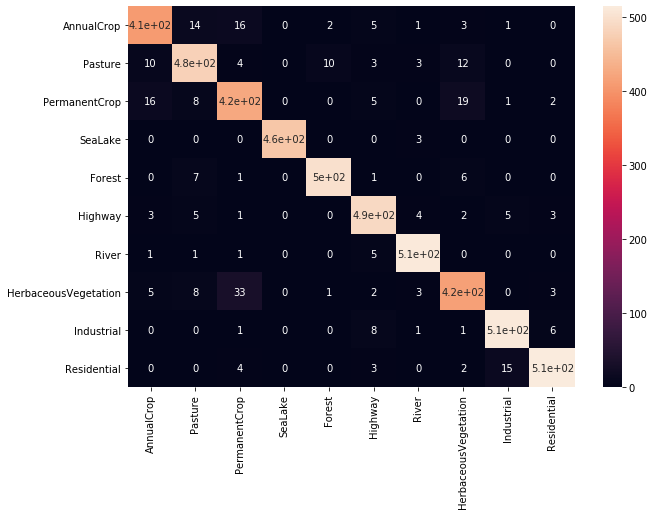

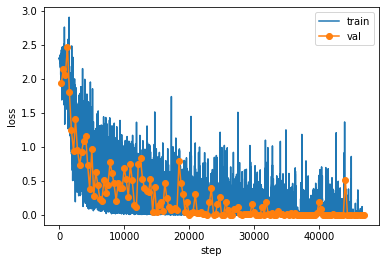

Finished Training... best model was model_epoch_41_step_39018.pth


In [16]:
steps_train = []
epoch_train = []
history_train = []

steps_val = []
history_val = []


best_model_conf_diag = 0
best_model_name = ""


global_steps = 0
for epoch in range(50):  # loop over the dataset multiple times

    model.train()
    
    for i, (inputs,labels) in enumerate(training_data_loader, 0):
                
        inputs = inputs.cuda()
        labels = labels.cuda().squeeze()
                
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        steps_train.append(global_steps)
        epoch_train.append(epoch)
        history_train.append(loss.item())
        global_steps += 1

        

        if (i % 10 == 0) and (i != 0):
            # print statistics
            print("Epoch",epoch ,'Iteration', i, 'Score:', loss.item(), end='\r')

        if (i % 300 == 0) and (i != 0):    

            # evaluate on validation set
            history_val.append(eval_model(val_data_loader, model))
            steps_val.append(global_steps)

            # calc conf mat
            cm = calc_conf_matrix(val_data_loader, model, classes)
            cm_diag = np.trace(cm)
            
            # if the diag sum is larger then the currently best then:
            if cm_diag > best_model_conf_diag:
                
                best_model_conf_diag = cm_diag

                
                # delete all the old checkpoints 
                files = glob.glob("./checkpoint/*.pth")
                for f in files:
                    os.remove(f)
                    
                # delete all the old checkpoints 
                files = glob.glob("./checkpoint/*.png")
                for f in files:
                    os.remove(f)

                
                # save plot
                plot_conf_matrix(cm.numpy(),savepath="./checkpoint/cm_epoch_{}_step_{}.png".format(epoch,global_steps))
                
                
                # save checkpoint
                state = {"epoch": epoch ,"model": model}
                model_out_path = os.path.join("./checkpoint","model_epoch_{}_step_{}.pth".format(epoch,global_steps))
                best_model_name = "model_epoch_{}_step_{}.pth".format(epoch,global_steps)
                
                os.makedirs("checkpoint/", exist_ok=True)
                torch.save(state, model_out_path)


        
    clear_output(wait=True)
    
    
    # plot conf matrix on validation set
    plot_conf_matrix(cm.numpy())
    
    # plot status
    plt.plot(steps_train,history_train,label="train")
    plt.plot(steps_val,history_val,label="val",marker ="o")
    plt.ylabel("loss")
    plt.xlabel("step")
    plt.legend()
    plt.show()
    
print('Finished Training... best model was',best_model_name)